## Makeover Monday | 2025/W51 New Year Resolution in US
Data sourced from YouGov US article's "What are Americans’ New Year’s resolutions for 2025?" (Jamie Ballard) first published Dec 13, 2024.
The purpose of this script it to load the data in via the published data set compiled by the Makeover Monday team for use in the Tableau [Makeover Monday](https://makeovermonday.co.uk/) Data Visualization challenge. Part of this notebook will also do initial EDA of the data and output to google sheets for seamless connect to Tableau Public.

Article link: https://today.yougov.com/society/articles/51144-what-are-americans-new-years-resolutions-for-2025
Compiled Data (published by Makeover Monday) see https://data.world/makeovermonday/2025w51-new-year-resolution-tweets-in-us

Taken from the Article:

**Methodology**: *This article includes results from an online survey conducted December 9 - 11, 2024 among **1,122** U.S. adult citizens. Respondents were selected from YouGov’s opt-in panel to be representative of adult U.S. citizens. The sample was weighted according to gender, age, race, education, 2024 presidential vote, 2020 election turnout and presidential vote, baseline party identification, and current voter registration status. 2024 presidential vote, at time of weighting, was estimated to be 48% Harris and 50% Trump. Demographic weighting targets come from the 2019 American Community Survey. Baseline party identification is the respondent’s most recent answer given around November 8, 2024, and is weighted to the estimated distribution at that time (31% Democratic, 32% Republican). The margin of error for the overall sample is approximately 4%.*

In [ ]:
import pandas as pd
df = pd.read_csv('https://query.data.world/s/evd6uxhyhmefhsnyheqivfklvc7sgb?dws=00000')

In [ ]:
df.head()

,Which New Year's Resolutions,U.S. adult citizens,18- to 29-year-olds,30- to 44-year-olds,45- to 64-year-olds,65 and older
0,Saving more money,26%,47%,31%,21%,8%
1,Improving physical health,22%,33%,21%,23%,12%
2,Exercising more,22%,41%,22%,17%,12%
3,Being happy,22%,45%,21%,17%,8%
4,Eating healthier,20%,30%,21%,21%,9%


In [ ]:
df.describe(include='all').T

,count,unique,top,freq
Which New Year's Resolutions,20,20,Saving more money,1
U.S. adult citizens,20,12,22%,3
18- to 29-year-olds,20,18,33%,2
30- to 44-year-olds,20,11,21%,3
45- to 64-year-olds,20,13,17%,3
65 and older,20,10,5%,3


In [ ]:
df.dtypes

,0
Which New Year's Resolutions,object
U.S. adult citizens,object
18- to 29-year-olds,object
30- to 44-year-olds,object
45- to 64-year-olds,object
65 and older,object


#The Shape of the Data
What does the shape of this data tell us and how should we clean it up to push to BigQuery Tableau to load to Tableau via Google Sheets (connect sheets)?
We can see from the 3 cell blocks above that there are already some issues with the data in its current format that will make it hard (not impossible) to make a nice viz in Tableau (or any BI tool). The main issues we have are:


*   Column Name Format: these are great for readability in articles, but BigQuery will not accept them, so I need to rename them.
*   All the Fields are Object Datatype: even though its clear that there are values (%'s!) the way we have pulled the data into the dataframe has all been as strings, so we need to convert the percentages into meaninful values with correct integer datatypes.
*   Age as Columns: it doesn't really make sense to have all the ages as columns - again, its great for reading these in aggregate in an article - but if we want to create some charts or do some comparative calculations its better to have fields that are the same in the same column as rows.

#Cleaning up the Data
In the next steps I will:


*   Rename Columns to be compataible with BigQuery
*   Convert the Percentage String values to Integers
*   Reshape the data by pivoting (or melting) the columns for Age to rows.

In [ ]:
#BigQuery does not like (or accept) weird names for columns which are nice for human readable table.
## this step renames the columns to be compatible with BigQuery and easy for ingestion
df = df.rename(columns={
    "Which New Year's Resolutions": "resolution",
    "U.S. adult citizens": "us_adults_avg", #I believe this is the average of all the age groups
    "18- to 29-year-olds": "age_18_29",
    "30- to 44-year-olds": "age_30_44",
    "45- to 64-year-olds": "age_45-64",
    "65 and older": "age_65_older"
})

df.head()

,resolution,us_adults_avg,age_18_29,age_30_44,age_45-64,age_65_older
0,Saving more money,26%,47%,31%,21%,8%
1,Improving physical health,22%,33%,21%,23%,12%
2,Exercising more,22%,41%,22%,17%,12%
3,Being happy,22%,45%,21%,17%,8%
4,Eating healthier,20%,30%,21%,21%,9%


In [ ]:
#also - as we could see above, all of the data types were strings
# obviously the values are percentages but straight casting astype() them would cause an error i.e.: "invalid literal for int() with base 10: '47%"
# this section loops though all of the data and FIRST replaces the "%" with "" and then converts to an int

for col in df.columns[1:]: #we skip over the resolution column because we dont want to convert that to an int()
  df[col] = (
      df[col]
      .str.replace("%","",regex=False) #replace the "%" with nothing!
      .astype(int) #cast at int
  )

df.dtypes #now check the types!

,0
resolution,object
us_adults_avg,int64
age_18_29,int64
age_30_44,int64
age_45-64,int64
age_65_older,int64


In [ ]:
## currents columns for Age are better suited as rows in a field
## This step reshapes the data using the pd.melt() function

df_long = df.melt(
    id_vars = ['resolution',"us_adults_avg"], #we will duplicate the us average accorss all the age groups as we can use this later on. This will be an aggregrated dimension in Tableau
    var_name = "age_group",
    value_name = "percent"
)

df_long.head(5)

,resolution,us_adults_avg,age_group,percent
0,Saving more money,26,age_18_29,47
1,Improving physical health,22,age_18_29,33
2,Exercising more,22,age_18_29,41
3,Being happy,22,age_18_29,45
4,Eating healthier,20,age_18_29,30


In [ ]:
df_long.tail(5) #just double check the last couple of rows too

,resolution,us_adults_avg,age_group,percent
75,Pursuing a career goal,11,age_65_older,1
76,Getting a new job,9,age_65_older,1
77,Spending more time with friends,9,age_65_older,3
78,Pursuing a new hobby,8,age_65_older,2
79,Moving,6,age_65_older,1


In [ ]:
#Sanity check for the schema of the final df_long!
df_long.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
resolution,80,20,Saving more money,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
us_adults_avg,80.0,NaN,NaN,NaN,14.75,5.31418,6.0,11.0,14.0,17.75,26.0
age_group,80,4,age_18_29,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
percent,80.0,NaN,NaN,NaN,15.1375,10.137964,1.0,8.0,13.0,21.0,47.0


#Save to BigQuery Table
Save the New df (df_long) to a dedicated table in my BigQuery warehouse
This is my final step before pushing it to a Google Sheet that I will use to connect to Tableau Public.

In [ ]:
#convert the df to target table in bigquery dataet
project_id = 'your_project_id'
destination_table = 'your_dataset.another_new_table'

df_long.to_gbq(
    destination_table=destination_table,
    project_id=project_id,
    if_exists='replace' ## 'if_exists' options: 'fail', 'replace', 'append'
)

/tmp/ipython-input-2737160551.py:5: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df_long.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 7825.19it/s]


#**Tableau Public Dashboard: [The Shift in New Years Resolution Priorities as we get Older](https://public.tableau.com/app/profile/allison.jones/viz/MoM2025_w51NewYearsResolutions/TheShiftinNewYearsResolutionPrioritiesaswegetOlder)**
Check out the final Tableau Dashboard that explores all of the various nuances of this "simple" dataset that we have cleaned in the code above.
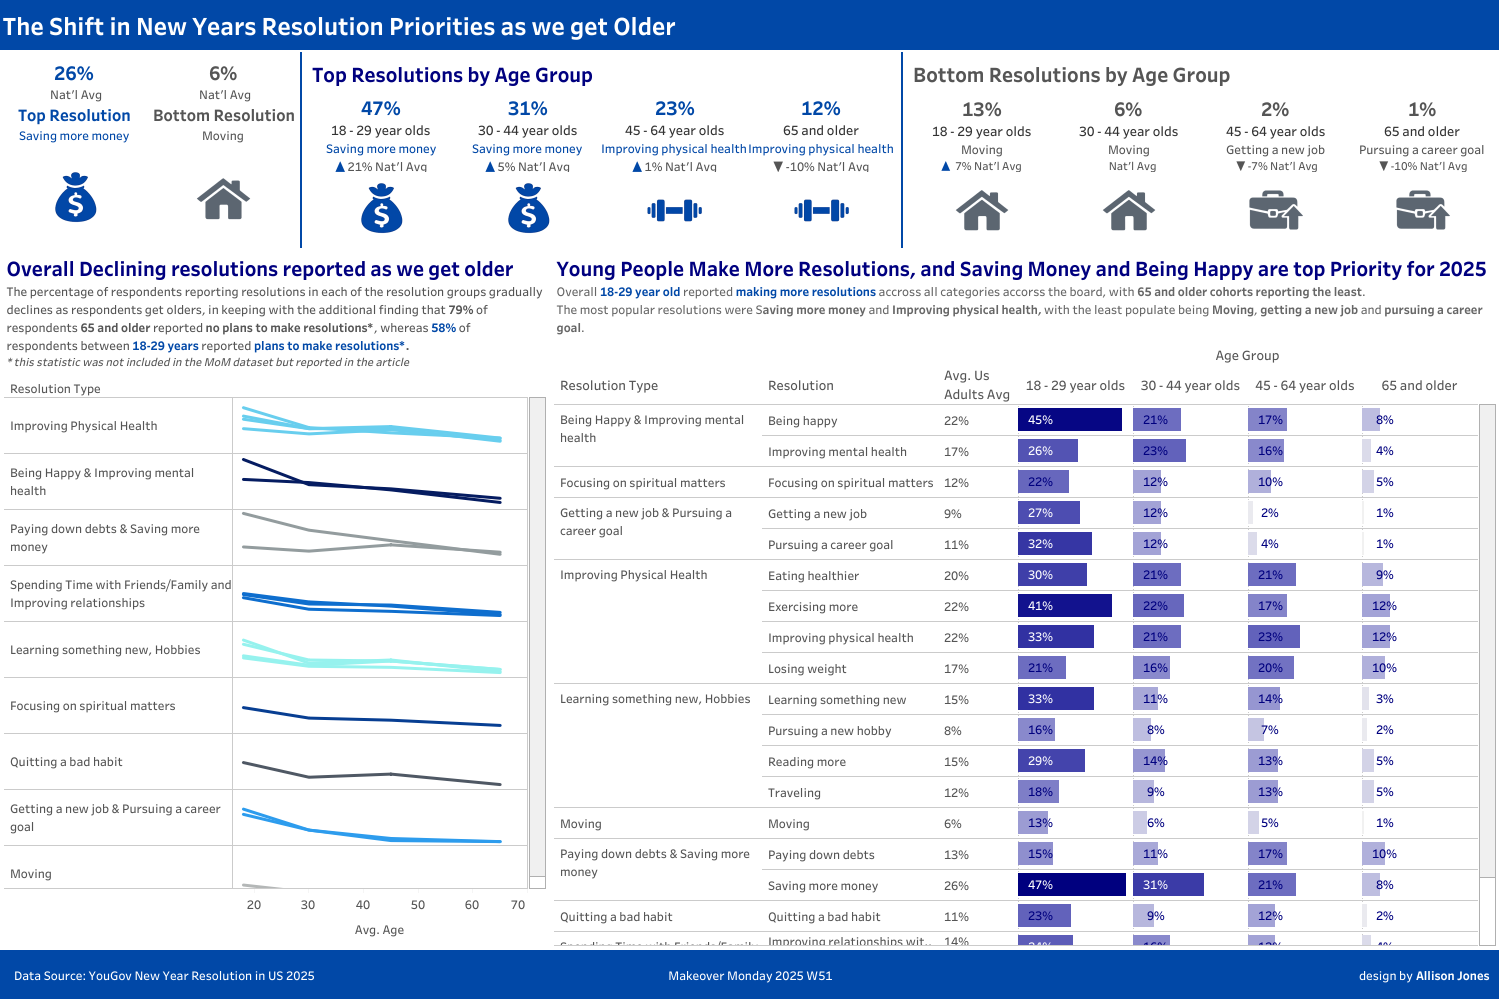